# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [445]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, SGD

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [446]:
# Define a function to load data and aggregate them
# path = r'C:\Users\adity\Documents\IIITB\Deep_Learning\RNN\Case_study\invoices\RNN_Stock_Starter_Dataset\RNN_Stocks_Data'
from google.colab import drive

drive.mount('/content/drive')
## Now you can access the content from the google drive on path /content/drive/MyDrive
## create the data dirctory
path = '/content/drive/MyDrive/Colab Notebooks/RNN_Case_study/RNN_Stocks_Data'

def csv_file_read_append(path):
    df = []#pd.DataFrame()
    csv_files = os.listdir(path)
    for csv in csv_files:
        full_path = os.path.join(path,csv)
        temp_read = pd.read_csv(full_path)
        df.append(temp_read)
    final_df = pd.concat(df,ignore_index = True)
    return final_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [447]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
all_csv_append = csv_file_read_append(path)
all_csv_append.Name.value_counts()


Name
IBM      3020
GOOGL    3019
AMZN     3019
MSFT     3019
Name: count, dtype: int64

In [448]:
# View specifics of the data
all_csv_append['Date'] = pd.to_datetime(all_csv_append['Date'])
all_csv_append['year'] = all_csv_append['Date'].dt.year
all_csv_append.head()


Date   Open   High    Low  Close    Volume Name  year
0 2006-01-03  82.45  82.55  80.81  82.06  11715200  IBM  2006
1 2006-01-04  82.20  82.50  81.33  81.95   9840600  IBM  2006
2 2006-01-05  81.40  82.90  81.00  82.50   7213500  IBM  2006
3 2006-01-06  83.95  85.03  83.41  84.95   8197400  IBM  2006
4 2006-01-09  84.10  84.25  83.38  83.73   6858200  IBM  2006

In [449]:
print(f"maximum year is {all_csv_append.groupby('Name')['year'].max()}")
print(f"minimum year is {all_csv_append.groupby('Name')['year'].min()}")

maximum year is Name
AMZN     2017
GOOGL    2017
IBM      2017
MSFT     2017
Name: year, dtype: int32
minimum year is Name
AMZN     2006
GOOGL    2006
IBM      2006
MSFT     2006
Name: year, dtype: int32


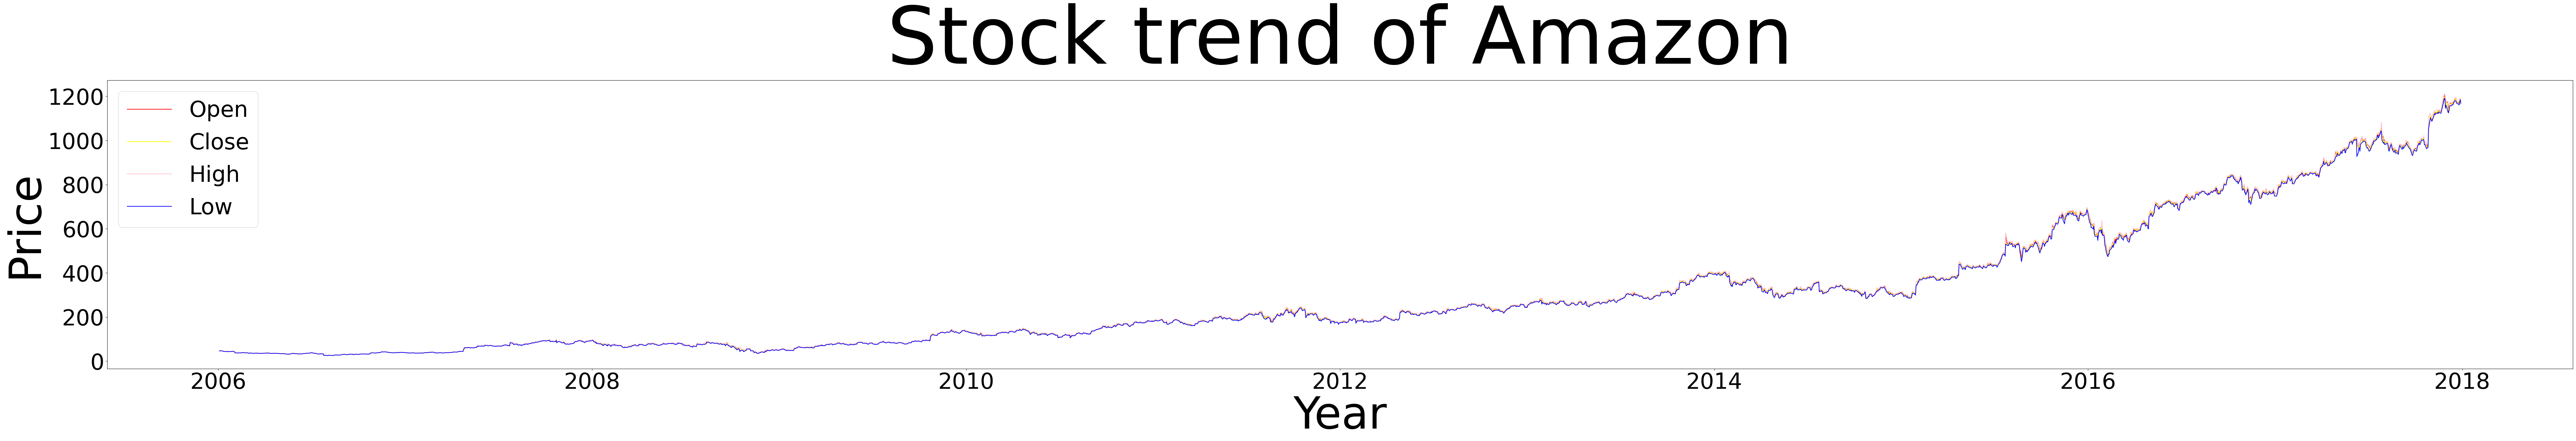

In [450]:
plt.figure(figsize=(100,40))
plt.subplot(3,1,1)
plt.plot(all_csv_append[all_csv_append['Name'] == 'AMZN']['Date'],all_csv_append[all_csv_append['Name'] == 'AMZN']['Open'], color= 'Red', label = 'Open')
plt.plot(all_csv_append[all_csv_append['Name'] == 'AMZN']['Date'],all_csv_append[all_csv_append['Name'] == 'AMZN']['Close'], color= 'Yellow', label = 'Close')
plt.plot(all_csv_append[all_csv_append['Name'] == 'AMZN']['Date'],all_csv_append[all_csv_append['Name'] == 'AMZN']['High'], color= 'pink', label = 'High')
plt.plot(all_csv_append[all_csv_append['Name'] == 'AMZN']['Date'],all_csv_append[all_csv_append['Name'] == 'AMZN']['Low'], color= 'Blue', label = 'Low')
plt.title('Stock trend of Amazon',fontsize = 180)
plt.ylabel('Price',fontsize=100)
plt.xlabel('Year',fontsize=100)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)


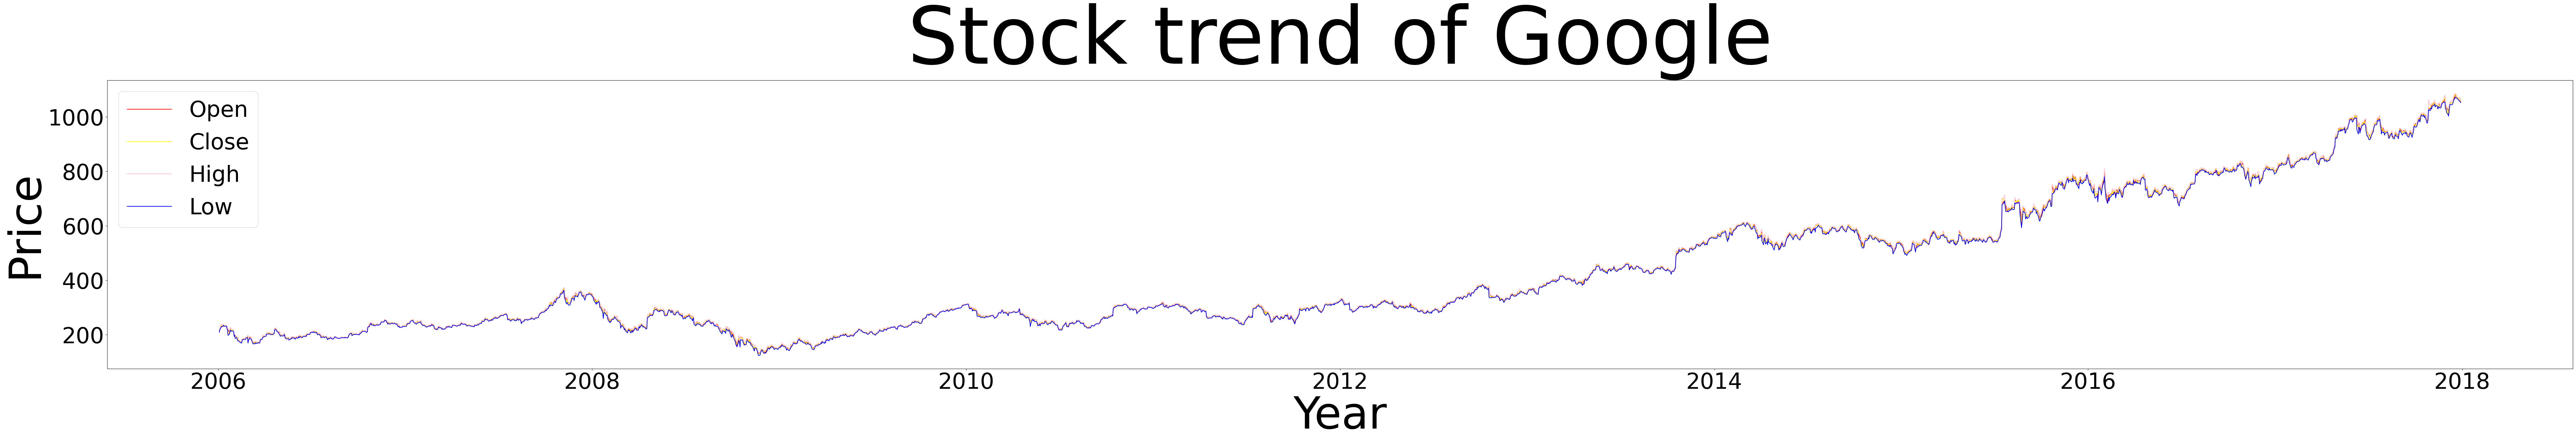

In [451]:
plt.figure(figsize=(100,40))
plt.subplot(3,1,1)
plt.plot(all_csv_append[all_csv_append['Name'] == 'GOOGL']['Date'],all_csv_append[all_csv_append['Name'] == 'GOOGL']['Open'], color= 'Red', label = 'Open')
plt.plot(all_csv_append[all_csv_append['Name'] == 'GOOGL']['Date'],all_csv_append[all_csv_append['Name'] == 'GOOGL']['Close'], color= 'Yellow', label = 'Close')
plt.plot(all_csv_append[all_csv_append['Name'] == 'GOOGL']['Date'],all_csv_append[all_csv_append['Name'] == 'GOOGL']['High'], color= 'pink', label = 'High')
plt.plot(all_csv_append[all_csv_append['Name'] == 'GOOGL']['Date'],all_csv_append[all_csv_append['Name'] == 'GOOGL']['Low'], color= 'Blue', label = 'Low')
plt.title('Stock trend of Google',fontsize = 180)
plt.ylabel('Price',fontsize=100)
plt.xlabel('Year',fontsize=100)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)

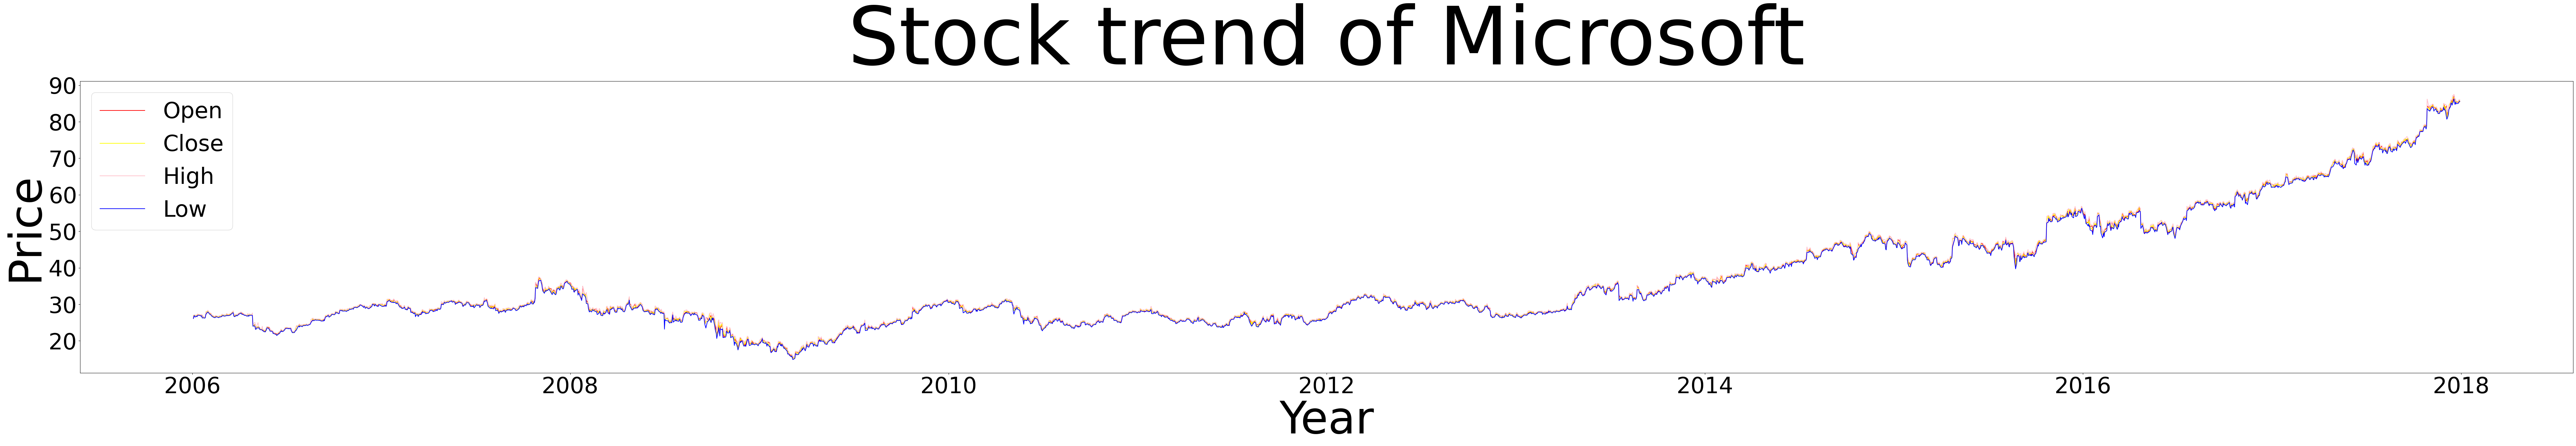

In [452]:
plt.figure(figsize=(100,40))
plt.subplot(3,1,1)
plt.plot(all_csv_append[all_csv_append['Name'] == 'MSFT']['Date'],all_csv_append[all_csv_append['Name'] == 'MSFT']['Open'], color= 'Red', label = 'Open')
plt.plot(all_csv_append[all_csv_append['Name'] == 'MSFT']['Date'],all_csv_append[all_csv_append['Name'] == 'MSFT']['Close'], color= 'Yellow', label = 'Close')
plt.plot(all_csv_append[all_csv_append['Name'] == 'MSFT']['Date'],all_csv_append[all_csv_append['Name'] == 'MSFT']['High'], color= 'pink', label = 'High')
plt.plot(all_csv_append[all_csv_append['Name'] == 'MSFT']['Date'],all_csv_append[all_csv_append['Name'] == 'MSFT']['Low'], color= 'Blue', label = 'Low')
plt.title('Stock trend of Microsoft',fontsize = 180)
plt.ylabel('Price',fontsize=100)
plt.xlabel('Year',fontsize=100)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)

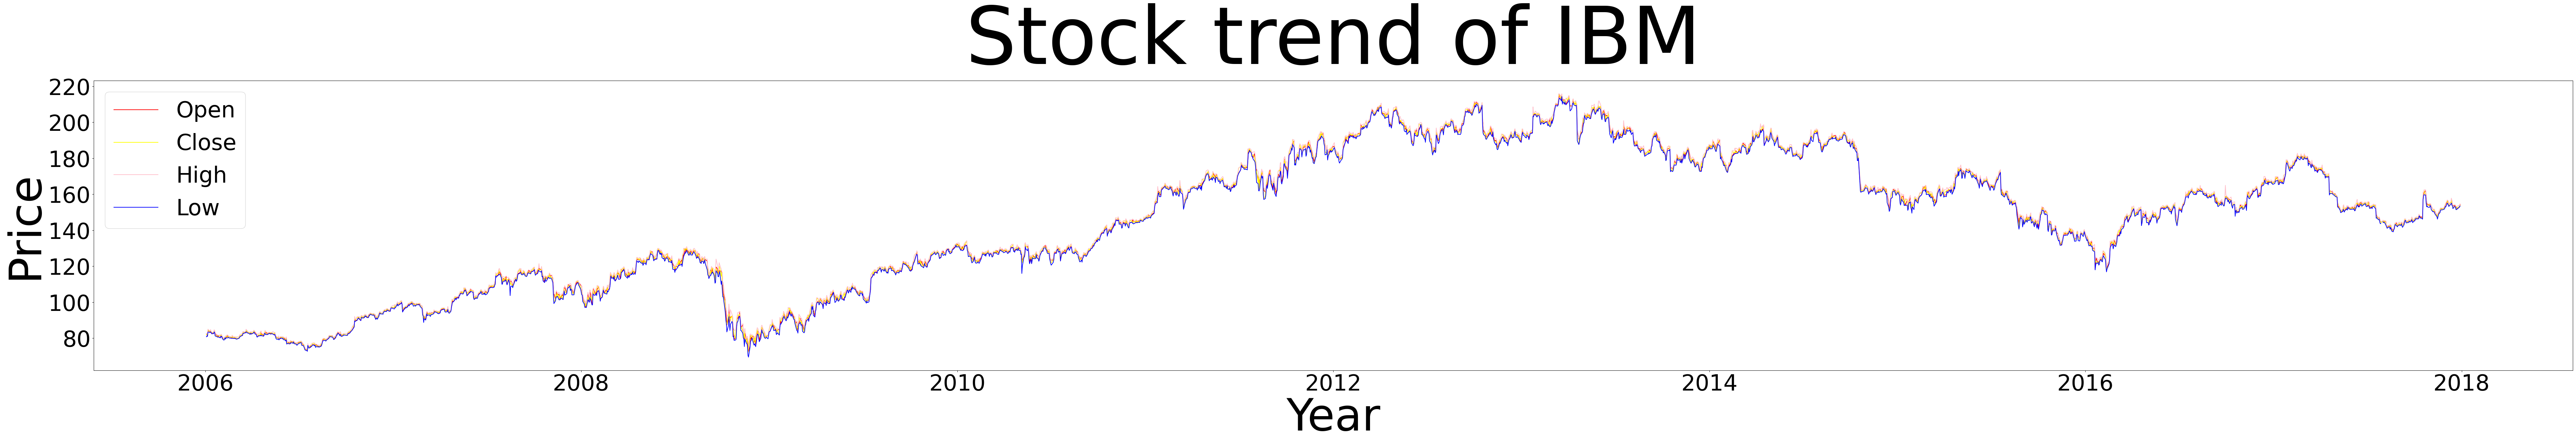

In [453]:
plt.figure(figsize=(100,40))
plt.subplot(3,1,1)
plt.plot(all_csv_append[all_csv_append['Name'] == 'IBM']['Date'],all_csv_append[all_csv_append['Name'] == 'IBM']['Open'], color= 'Red', label = 'Open')
plt.plot(all_csv_append[all_csv_append['Name'] == 'IBM']['Date'],all_csv_append[all_csv_append['Name'] == 'IBM']['Close'], color= 'Yellow', label = 'Close')
plt.plot(all_csv_append[all_csv_append['Name'] == 'IBM']['Date'],all_csv_append[all_csv_append['Name'] == 'IBM']['High'], color= 'pink', label = 'High')
plt.plot(all_csv_append[all_csv_append['Name'] == 'IBM']['Date'],all_csv_append[all_csv_append['Name'] == 'IBM']['Low'], color= 'Blue', label = 'Low')
plt.title('Stock trend of IBM',fontsize = 180)
plt.ylabel('Price',fontsize=100)
plt.xlabel('Year',fontsize=100)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [454]:
# Handle Missing Values

all_csv_append.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
year      0
dtype: int64

In [455]:
all_csv_append.shape

(12077, 8)

In [456]:
all_csv_append[all_csv_append['Open'].isnull()]

Date  Open    High  Low   Close   Volume Name  year
2913 2017-07-31   NaN  144.93  NaN  144.67  4355718  IBM  2017

In [457]:
all_csv_append[all_csv_append['Low'].isnull()]

Date  Open    High  Low   Close   Volume Name  year
2913 2017-07-31   NaN  144.93  NaN  144.67  4355718  IBM  2017

In [458]:
all_stocks = all_csv_append.copy()

In [459]:
all_stocks.dropna(inplace = True)

In [460]:
all_stocks.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
year      0
dtype: int64

In [461]:
all_stocks.shape

(12076, 8)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

count    3.019000e+03
mean     5.931712e+06
std      5.122034e+06
min      9.864350e+05
25%      3.137037e+06
50%      4.724100e+06
75%      7.135246e+06
max      1.044046e+08
Name: Volume, dtype: float64

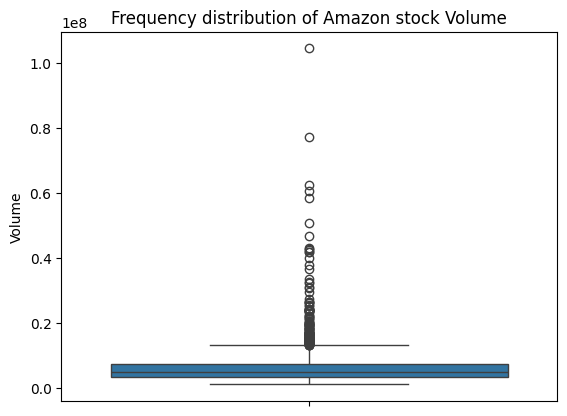

In [462]:
# Frequency distribution of volumes
plt.title('Frequency distribution of Amazon stock Volume')
sns.boxplot(y = all_stocks[all_stocks['Name'] == 'AMZN']['Volume'])
all_stocks[all_stocks['Name'] == 'AMZN'].Volume.describe()

count    3.019000e+03
mean     3.551504e+06
std      3.038599e+06
min      5.211410e+05
25%      1.760854e+06
50%      2.517630e+06
75%      4.242182e+06
max      4.118289e+07
Name: Volume, dtype: float64

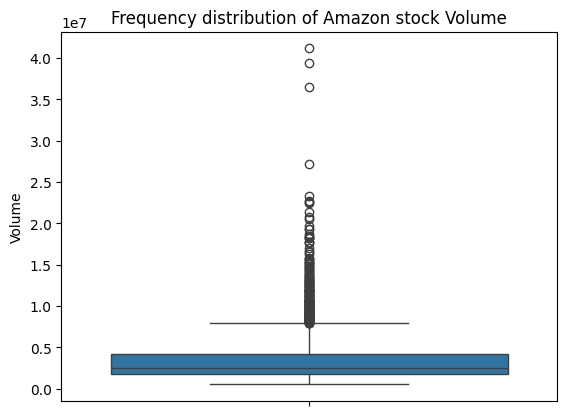

In [463]:
plt.title('Frequency distribution of Amazon stock Volume')
sns.boxplot(y = all_stocks[all_stocks['Name'] == 'GOOGL']['Volume'])
all_stocks[all_stocks['Name'] == 'GOOGL'].Volume.describe()

count    3.019000e+03
mean     5.161762e+07
std      3.114958e+07
min      7.425603e+06
25%      3.136557e+07
50%      4.617529e+07
75%      6.322291e+07
max      5.910786e+08
Name: Volume, dtype: float64

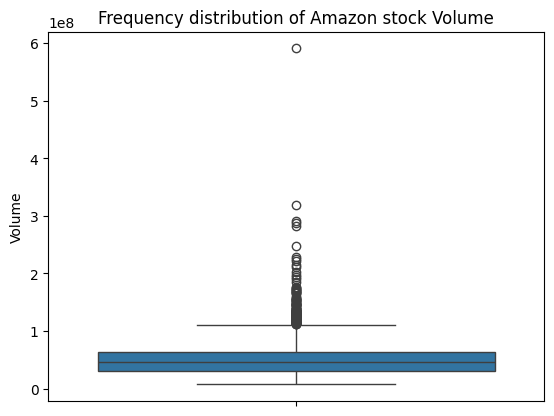

In [464]:
plt.title('Frequency distribution of Amazon stock Volume')
sns.boxplot(y = all_stocks[all_stocks['Name'] == 'MSFT']['Volume'])
all_stocks[all_stocks['Name'] == 'MSFT'].Volume.describe()

count    3.019000e+03
mean     5.773770e+06
std      3.193255e+06
min      2.542560e+05
25%      3.622178e+06
50%      4.931203e+06
75%      6.966642e+06
max      3.077428e+07
Name: Volume, dtype: float64

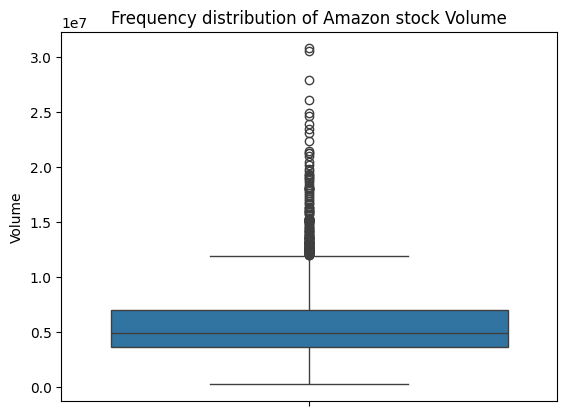

In [465]:
plt.title('Frequency distribution of Amazon stock Volume')
sns.boxplot(y = all_stocks[all_stocks['Name'] == 'IBM']['Volume'])
all_stocks[all_stocks['Name'] == 'IBM'].Volume.describe()

In [466]:
# Stock volume variation over time
plt.figure(figsize = (100,100))
plt.subplot(4,1,1)
plt.title('Amazon', fontsize = 100)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)
plt.plot(all_csv_append[all_csv_append['Name'] == 'AMZN']['Date'],all_csv_append[all_csv_append['Name'] == 'AMZN']['Volume'], color= 'Red', label = 'Open')
plt.subplot(4,1,2)
plt.title('Google', fontsize = 100)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)
plt.plot(all_csv_append[all_csv_append['Name'] == 'GOOGL']['Date'],all_csv_append[all_csv_append['Name'] == 'GOOGL']['Volume'], color= 'Yellow', label = 'Close')
plt.subplot(4,1,3)
plt.title('IBM', fontsize = 100)
plt.plot(all_csv_append[all_csv_append['Name'] == 'IBM']['Date'],all_csv_append[all_csv_append['Name'] == 'IBM']['Volume'], color= 'pink', label = 'High')
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)
plt.subplot(4,1,4)
plt.title('Microsoft', fontsize = 100)
plt.plot(all_csv_append[all_csv_append['Name'] == 'MSFT']['Date'],all_csv_append[all_csv_append['Name'] == 'MSFT']['Volume'], color= 'Blue', label = 'Low')
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(fontsize = 50)

Output hidden; open in https://colab.research.google.com to view.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

<Axes: >

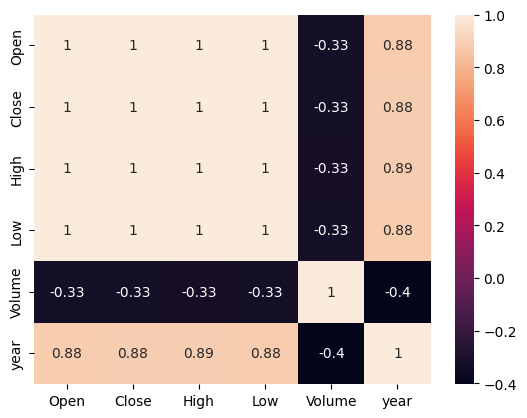

In [467]:
# Analyse correlations
corr = all_stocks[all_stocks['Name']=='AMZN'][['Open','Close','High','Low','Volume','year']].corr()
sns.heatmap(corr, annot = True)


In [468]:
all_stocks['day'] = all_stocks['Date'].dt.day
all_stocks['month'] = all_stocks['Date'].dt.month
all_stocks['year'] = all_stocks['Date'].dt.year
all_stocks['day_of_week'] = all_stocks['Date'].dt.weekday
all_stocks['day_of_year'] = all_stocks['Date'].dt.dayofyear

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [469]:
# Define a function that divides the data into windows and generates target variable values for each window
# for function testing taking subset of all_stocks dataframe
amzn = all_stocks[all_stocks['Name'] == 'AMZN'][['Date', 'Name','Close','day','month','year','day_of_week','day_of_year']]

In [470]:
def create_windows(df, stock_name, window_size = 3, stride_size = 1):
    df = df[df['Name'].isin(stock_name)]
    df['Name'] = df['Name'].map({'AMZN':1 , 'GOOGL':2, 'IBM':3, 'MSFT':4})
    df['Name'] = df['Name'].astype(int)
    df = df.sort_values(by = ['Name','Date'])
    window = []
    for name, group in df.groupby('Name'):
        group = group.reset_index(drop = True)
        for i in range(0,len(group)-window_size, stride_size):
            window_df = group.iloc[i:i+window_size]
            print(i,i+window_size)
            #print(window_df)
            if i + window_size < len(group):
              print(i + window_size, len(group))
              target_price = group.iloc[i+window_size]['Close']
              print(target_price)
              #print(window)
              window.append({
                  'X': window_df[['Date', 'Name','day','month','year','day_of_week','day_of_year']].copy(),
                  'y': target_price
                  })
              #print(window)
    return window

window_all_stocks = create_windows(all_stocks, ['AMZN','GOOGL'], window_size = 5, stride_size = 1)

<ipython-input-470-0c70cba956a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].map({'AMZN':1 , 'GOOGL':2, 'IBM':3, 'MSFT':4})
<ipython-input-470-0c70cba956a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].astype(int)


Streaming output truncated to the last 5000 lines.
1352 3019
265.17
1348 1353
1353 3019
265.89
1349 1354
1354 3019
262.28
1350 1355
1355 3019
259.45
1351 1356
1356 3019
259.39
1352 1357
1357 3019
260.09
1353 1358
1358 3019
259.32
1354 1359
1359 3019
260.71
1355 1360
1360 3019
264.77
1356 1361
1361 3019
263.06
1357 1362
1362 3019
264.29
1358 1363
1363 3019
261.8
1359 1364
1364 3019
260.79
1360 1365
1365 3019
259.77
1361 1366
1366 3019
259.84
1362 1367
1367 3019
258.62
1363 1368
1368 3019
255.01
1364 1369
1369 3019
252.62
1365 1370
1370 3019
254.44
1366 1371
1371 3019
251.73
1367 1372
1372 3019
250.44
1368 1373
1373 3019
242.75
1369 1374
1374 3019
242.53
1370 1375
1375 3019
246.75
1371 1376
1376 3019
243.75
1372 1377
1377 3019
240.35
1373 1378
1378 3019
237.68
1374 1379
1379 3019
241.6
1375 1380
1380 3019
247.07
1376 1381
1381 3019
249.03
1377 1382
1382 3019
253.44
1378 1383
1383 3019
260.78
1379 1384
1384 3019
266.49
1380 1385
1385 3019
267.95
1381 1386
1386 3019
273.57
1382 1387
1387 3

In [471]:
window_all_stocks

[{'X':         Date  Name  day  month  year  day_of_week  day_of_year
  0 2006-01-03     1    3      1  2006            1            3
  1 2006-01-04     1    4      1  2006            2            4
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     1    6      1  2006            4            6
  4 2006-01-09     1    9      1  2006            0            9,
  'y': np.float64(45.65)},
 {'X':         Date  Name  day  month  year  day_of_week  day_of_year
  1 2006-01-04     1    4      1  2006            2            4
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     1    6      1  2006            4            6
  4 2006-01-09     1    9      1  2006            0            9
  5 2006-01-10     1   10      1  2006            1           10,
  'y': np.float64(44.93)},
 {'X':         Date  Name  day  month  year  day_of_week  day_of_year
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     

In [472]:
#window_all_stocks[10000]['X'][window_all_stocks[10000]['X']['Name'] == 'MSFT']

In [473]:
window_all_stocks

[{'X':         Date  Name  day  month  year  day_of_week  day_of_year
  0 2006-01-03     1    3      1  2006            1            3
  1 2006-01-04     1    4      1  2006            2            4
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     1    6      1  2006            4            6
  4 2006-01-09     1    9      1  2006            0            9,
  'y': np.float64(45.65)},
 {'X':         Date  Name  day  month  year  day_of_week  day_of_year
  1 2006-01-04     1    4      1  2006            2            4
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     1    6      1  2006            4            6
  4 2006-01-09     1    9      1  2006            0            9
  5 2006-01-10     1   10      1  2006            1           10,
  'y': np.float64(44.93)},
 {'X':         Date  Name  day  month  year  day_of_week  day_of_year
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     

In [474]:
all_stocks.Name.value_counts()

Name
IBM      3019
GOOGL    3019
AMZN     3019
MSFT     3019
Name: count, dtype: int64

In [475]:
window_all_stocks[0]['y']

np.float64(45.65)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [476]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def window_scaling(df):
    length_windows = len(df)
    scaler = StandardScaler()
    y_scaler = StandardScaler()
    for i in range(length_windows):
        df[i]['X']['Date'] = pd.to_datetime(df[i]['X']['Date'])
        #df[i]['X'][['Close']] = df[i]['X'][['Close']].astype(float)
        #scaler.partial_fit(df[i]['X'][['Close']])
        #df[i]['X'][['Close']] = scaler.transform(df[i]['X'][['Close']])

        all_y = np.array([entry['y'] for entry in df]).reshape(-1, 1)
        y_scaler.fit(all_y)
    for i in range(length_windows):
        #df[i]['X']['Close'] = scaler.transform(df[i]['X'][['Close']])
        df[i]['y'] = y_scaler.transform(np.array([[df[i]['y']]]))[0][0]
    return df

abc = window_scaling(window_all_stocks)

In [477]:
abc

[{'X':         Date  Name  day  month  year  day_of_week  day_of_year
  0 2006-01-03     1    3      1  2006            1            3
  1 2006-01-04     1    4      1  2006            2            4
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     1    6      1  2006            4            6
  4 2006-01-09     1    9      1  2006            0            9,
  'y': np.float64(-1.1928904920646266)},
 {'X':         Date  Name  day  month  year  day_of_week  day_of_year
  1 2006-01-04     1    4      1  2006            2            4
  2 2006-01-05     1    5      1  2006            3            5
  3 2006-01-06     1    6      1  2006            4            6
  4 2006-01-09     1    9      1  2006            0            9
  5 2006-01-10     1   10      1  2006            1           10,
  'y': np.float64(-1.1955876773510727)},
 {'X':         Date  Name  day  month  year  day_of_week  day_of_year
  2 2006-01-05     1    5      1  2006            3     

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [478]:
# Define a function to create input and output data points from the master DataFrame

def window_train_test(df, stock_name, window_size = 5, stride_size = 1, train_split = 0.8):
    window_all_stocks = create_windows(df, stock_name, window_size = window_size, stride_size = stride_size)
    scaled_window_df = window_scaling(window_all_stocks)
    train, test = train_test_split(scaled_window_df, train_size = train_split, shuffle = False)
    X_train = [window['X'] for window in train]
    y_train = [window['y'] for window in train]
    X_test = [window['X'] for window in test]
    y_test = [window['y'] for window in test]
    return X_train, y_train, X_test, y_test


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [479]:
# Checking for patterns in different sequence lengths
quarterly_var = all_stocks.groupby(['Name',all_stocks['Date'].dt.to_period('Q')])['Close'].var().reset_index()
quarterly_var['Date'] = quarterly_var['Date'].dt.to_timestamp()


In [480]:
quarterly_var.groupby('Name')['Close'].describe()

count        mean          std        min         25%         50%  \
Name                                                                       
AMZN    48.0  516.443438  1069.668546   1.444102   49.137774  123.950958   
GOOGL   48.0  461.807421   553.278263  58.795293  137.613858  318.286435   
IBM     48.0   26.911824    22.529468   2.058065    9.625184   19.282479   
MSFT    48.0    2.805699     2.648252   0.170545    0.896872    1.987911   

              75%          max  
Name                            
AMZN   505.750884  6577.265348  
GOOGL  453.747635  2834.760728  
IBM     37.915474   102.581326  
MSFT     4.046249    12.667297

In [481]:
monthly_var = all_stocks.groupby(['Name',all_stocks['Date'].dt.to_period('M')])['Close'].var().reset_index()
monthly_var['Date'] = monthly_var['Date'].dt.to_timestamp()

In [482]:
monthly_var.groupby('Name')['Close'].describe()

count        mean         std       min        25%        50%  \
Name                                                                   
AMZN   144.0  132.008904  263.391007  0.306287  14.168741  38.935321   
GOOGL  144.0  176.356082  349.079947  6.692627  38.909950  82.290051   
IBM    144.0   12.000673   15.719162  0.360004   3.250762   6.512046   
MSFT   144.0    1.001713    1.471268  0.031605   0.303456   0.501222   

              75%          max  
Name                            
AMZN   128.178102  2039.041924  
GOOGL  202.966504  3709.347579  
IBM     16.118317   128.832004  
MSFT     0.985879     9.512904

In [483]:
weekly_var = all_stocks.groupby(['Name',all_stocks['Date'].dt.to_period('W')])['Close'].var().reset_index()
weekly_var['Date'] = weekly_var['Date'].dt.to_timestamp()

In [484]:
weekly_var.groupby('Name')['Close'].describe()

count       mean         std      min       25%        50%        75%  \
Name                                                                           
AMZN   626.0  43.726526  158.983064  0.01337  2.279913   8.231429  31.375655   
GOOGL  626.0  48.373017  135.844403  0.11213  7.162233  16.828000  43.101292   
IBM    626.0   3.555865    6.803799  0.01908  0.539737   1.462450   3.580645   
MSFT   626.0   0.300859    0.605447  0.00305  0.052632   0.125875   0.295472   

              max  
Name               
AMZN   3343.71987  
GOOGL  2723.35428  
IBM      79.17043  
MSFT      6.65333

In [485]:
all_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12076 entries, 0 to 12076
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         12076 non-null  datetime64[ns]
 1   Open         12076 non-null  float64       
 2   High         12076 non-null  float64       
 3   Low          12076 non-null  float64       
 4   Close        12076 non-null  float64       
 5   Volume       12076 non-null  int64         
 6   Name         12076 non-null  object        
 7   year         12076 non-null  int32         
 8   day          12076 non-null  int32         
 9   month        12076 non-null  int32         
 10  day_of_week  12076 non-null  int32         
 11  day_of_year  12076 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(5), int64(1), object(1)
memory usage: 990.6+ KB


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [486]:
# Create data instances from the master data frame using decided window size and window stride
# From above analysis the major visible median variation over the period of quarter.
# Maximum variations are almost comparable with each other so as minimum.
# Decision: Window of Quarter/90 days and stride of week or 1 days.

X_train_amzn, y_train_amzn , X_test_amzn, y_test_amzn= window_train_test(all_stocks, ['AMZN'],window_size = 90, stride_size = 1, train_split = 0.8 )
X_train_googl, y_train_googl , X_test_googl, y_test_googl= window_train_test(all_stocks, ['GOOGL'],window_size = 90, stride_size = 1, train_split = 0.8 )
X_train_IBM, y_train_IBM , X_test_IBM, y_test_IBM= window_train_test(all_stocks, ['IBM'],window_size = 90, stride_size = 1, train_split = 0.8 )
X_train_msft, y_train_msft , X_test_msft, y_test_msft= window_train_test(all_stocks, ['MSFT'],window_size = 90, stride_size = 1, train_split = 0.8 )
#X_train, y_train , X_test, y_test= window_train_test(all_stocks, ['AMZN','MSFT','GOOGL','IBM'],window_size = 90, stride_size = 1, train_split = 0.8 )

0 90
90 3019
32.73
1 91
91 3019
32.78
2 92
92 3019
32.76
3 93
93 3019
31.61
4 94
94 3019
32.61
5 95
95 3019
33.94
6 96
96 3019
34.83
7 97
97 3019
33.76
8 98
98 3019
35.19
9 99
99 3019
35.63
10 100
100 3019
36.07
11 101
101 3019
34.64
12 102
102 3019
34.61
13 103
103 3019
35.07
14 104
104 3019
34.76
15 105
105 3019
33.49
16 106
106 3019
33.41
17 107
107 3019
33.77
18 108
108 3019
33.55
19 109
109 3019
33.78
20 110
110 3019
33.6
21 111
111 3019
33.47
22 112
112 3019
33.68
23 113
113 3019
34.96
24 114
114 3019
35.09
25 115
115 3019
35.07
26 116
116 3019
35.48
27 117
117 3019
36.65
28 118
118 3019
36.37
29 119
119 3019
36.55
30 120
120 3019
36.77
31 121
121 3019
36.48
32 122
122 3019
36.7
33 123
123 3019
38.52
34 124
124 3019
38.68
35 125
125 3019
38.61
36 126
126 3019
37.11
37 127
127 3019
36.8
38 128
128 3019
36.11
39 129
129 3019
35.79
40 130
130 3019
35.66
41 131
131 3019
34.63
42 132
132 3019
33.73
43 133
133 3019
32.92
44 134
134 3019
33.67
45 135
135 3019
33.49
46 136
136 3019
34.48

<ipython-input-470-0c70cba956a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].map({'AMZN':1 , 'GOOGL':2, 'IBM':3, 'MSFT':4})
<ipython-input-470-0c70cba956a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].astype(int)


Streaming output truncated to the last 5000 lines.
1352 3019
197.09
1263 1353
1353 3019
198.8
1264 1354
1354 3019
198.65
1265 1355
1355 3019
196.22
1266 1356
1356 3019
193.27
1267 1357
1357 3019
192.26
1268 1358
1358 3019
195.0
1269 1359
1359 3019
194.13
1270 1360
1360 3019
196.69
1271 1361
1361 3019
192.4
1272 1362
1362 3019
193.65
1273 1363
1363 3019
188.32
1274 1364
1364 3019
185.69
1275 1365
1365 3019
187.55
1276 1366
1366 3019
188.05
1277 1367
1367 3019
189.68
1278 1368
1368 3019
186.53
1279 1369
1369 3019
186.29
1280 1370
1370 3019
189.96
1281 1371
1371 3019
185.98
1282 1372
1372 3019
183.65
1283 1373
1373 3019
186.37
1284 1374
1374 3019
187.72
1285 1375
1375 3019
194.23
1286 1376
1376 3019
191.63
1287 1377
1377 3019
194.16
1288 1378
1378 3019
192.55
1289 1379
1379 3019
201.25
1290 1380
1380 3019
202.35
1291 1381
1381 3019
204.18
1292 1382
1382 3019
204.49
1293 1383
1383 3019
209.49
1294 1384
1384 3019
213.19
1295 1385
1385 3019
214.19
1296 1386
1386 3019
216.74
1297 1387
1387 30

<ipython-input-470-0c70cba956a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].map({'AMZN':1 , 'GOOGL':2, 'IBM':3, 'MSFT':4})
<ipython-input-470-0c70cba956a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].astype(int)


Streaming output truncated to the last 5000 lines.
1352 3019
265.17
1263 1353
1353 3019
265.89
1264 1354
1354 3019
262.28
1265 1355
1355 3019
259.45
1266 1356
1356 3019
259.39
1267 1357
1357 3019
260.09
1268 1358
1358 3019
259.32
1269 1359
1359 3019
260.71
1270 1360
1360 3019
264.77
1271 1361
1361 3019
263.06
1272 1362
1362 3019
264.29
1273 1363
1363 3019
261.8
1274 1364
1364 3019
260.79
1275 1365
1365 3019
259.77
1276 1366
1366 3019
259.84
1277 1367
1367 3019
258.62
1278 1368
1368 3019
255.01
1279 1369
1369 3019
252.62
1280 1370
1370 3019
254.44
1281 1371
1371 3019
251.73
1282 1372
1372 3019
250.44
1283 1373
1373 3019
242.75
1284 1374
1374 3019
242.53
1285 1375
1375 3019
246.75
1286 1376
1376 3019
243.75
1287 1377
1377 3019
240.35
1288 1378
1378 3019
237.68
1289 1379
1379 3019
241.6
1290 1380
1380 3019
247.07
1291 1381
1381 3019
249.03
1292 1382
1382 3019
253.44
1293 1383
1383 3019
260.78
1294 1384
1384 3019
266.49
1295 1385
1385 3019
267.95
1296 1386
1386 3019
273.57
1297 1387
1387 3

<ipython-input-470-0c70cba956a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].map({'AMZN':1 , 'GOOGL':2, 'IBM':3, 'MSFT':4})
<ipython-input-470-0c70cba956a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].astype(int)


Streaming output truncated to the last 5000 lines.
1352 3019
170.5
1263 1353
1353 3019
170.44
1264 1354
1354 3019
170.59
1265 1355
1355 3019
170.16
1266 1356
1356 3019
168.26
1267 1357
1357 3019
167.99
1268 1358
1358 3019
167.75
1269 1359
1359 3019
167.18
1270 1360
1360 3019
167.5
1271 1361
1361 3019
168.93
1272 1362
1362 3019
166.56
1273 1363
1363 3019
166.09
1274 1364
1364 3019
165.05
1275 1365
1365 3019
164.75
1276 1366
1366 3019
163.69
1277 1367
1367 3019
164.34
1278 1368
1368 3019
164.84
1279 1369
1369 3019
163.18
1280 1370
1370 3019
163.17
1281 1371
1371 3019
164.12
1282 1372
1372 3019
162.33
1283 1373
1373 3019
162.67
1284 1374
1374 3019
164.44
1285 1375
1375 3019
165.02
1286 1376
1376 3019
166.22
1287 1377
1377 3019
165.68
1288 1378
1378 3019
166.12
1289 1379
1379 3019
165.07
1290 1380
1380 3019
167.62
1291 1381
1381 3019
170.01
1292 1382
1382 3019
170.54
1293 1383
1383 3019
171.55
1294 1384
1384 3019
174.54
1295 1385
1385 3019
175.43
1296 1386
1386 3019
177.71
1297 1387
1387 3

<ipython-input-470-0c70cba956a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].map({'AMZN':1 , 'GOOGL':2, 'IBM':3, 'MSFT':4})
<ipython-input-470-0c70cba956a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].astype(int)


Streaming output truncated to the last 5000 lines.
1352 3019
24.69
1263 1353
1353 3019
24.72
1264 1354
1354 3019
24.49
1265 1355
1355 3019
24.17
1266 1356
1356 3019
24.15
1267 1357
1357 3019
24.19
1268 1358
1358 3019
24.67
1269 1359
1359 3019
24.76
1270 1360
1360 3019
25.01
1271 1361
1361 3019
24.43
1272 1362
1362 3019
24.22
1273 1363
1363 3019
23.9
1274 1364
1364 3019
24.01
1275 1365
1365 3019
24.06
1276 1366
1366 3019
23.94
1277 1367
1367 3019
23.96
1278 1368
1368 3019
23.7
1279 1369
1369 3019
24.04
1280 1370
1370 3019
24.22
1281 1371
1371 3019
23.74
1282 1372
1372 3019
24.0
1283 1373
1373 3019
24.26
1284 1374
1374 3019
24.47
1285 1375
1375 3019
24.76
1286 1376
1376 3019
24.65
1287 1377
1377 3019
24.63
1288 1378
1378 3019
24.3
1289 1379
1379 3019
25.2
1290 1380
1380 3019
25.8
1291 1381
1381 3019
25.62
1292 1382
1382 3019
26.0
1293 1383
1383 3019
26.02
1294 1384
1384 3019
26.03
1295 1385
1385 3019
26.33
1296 1386
1386 3019
26.77
1297 1387
1387 3019
26.92
1298 1388
1388 3019
26.63
1299

In [487]:
# Check the number of data points generated
X_train_amzn[0]

Date  Name  day  month  year  day_of_week  day_of_year
0  2006-01-03     1    3      1  2006            1            3
1  2006-01-04     1    4      1  2006            2            4
2  2006-01-05     1    5      1  2006            3            5
3  2006-01-06     1    6      1  2006            4            6
4  2006-01-09     1    9      1  2006            0            9
..        ...   ...  ...    ...   ...          ...          ...
85 2006-05-05     1    5      5  2006            4          125
86 2006-05-08     1    8      5  2006            0          128
87 2006-05-09     1    9      5  2006            1          129
88 2006-05-10     1   10      5  2006            2          130
89 2006-05-11     1   11      5  2006            3          131

[90 rows x 7 columns]

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [488]:
# Check if the datasets are compatible inputs to neural networks
X_train_array = np.array([df[['Name','Close','day','month','year','day_of_week','day_of_year']].values for df in X_train])  # (samples, timesteps, features)
y_train_array = np.array([float(y) for y in y_train])

In [489]:
X_train_amzn_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_train_amzn])  # (samples, timesteps, features)
y_train_amzn_array = np.array([float(y) for y in y_train_amzn])

In [490]:
X_train_googl_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_train_googl])  # (samples, timesteps, features)
y_train_googl_array = np.array([float(y) for y in y_train_googl])

In [491]:
X_train_IBM_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_train_IBM])  # (samples, timesteps, features)
y_train_IBM_array = np.array([float(y) for y in y_train_IBM])

In [492]:
X_train_msft_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_train_msft])  # (samples, timesteps, features)
y_train_msft_array = np.array([float(y) for y in y_train_msft])

In [493]:
X_train_amzn_array.shape

(2343, 90, 6)

In [494]:
X_test_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_test])  # (samples, timesteps, features)
y_test_array = np.array([float(y) for y in y_test])
X_test_amzn_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_test_amzn])  # (samples, timesteps, features)
y_test_amzn_array = np.array([float(y) for y in y_test_amzn])
X_test_googl_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_test_googl])  # (samples, timesteps, features)
y_test_googl_array = np.array([float(y) for y in y_test_googl])
X_test_IBM_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_test_IBM])  # (samples, timesteps, features)
y_test_IBM_array = np.array([float(y) for y in y_test_IBM])
X_test_msft_array = np.array([df[['Name','day','month','year','day_of_week','day_of_year']].values for df in X_test_msft])  # (samples, timesteps, features)
y_test_msft_array = np.array([float(y) for y in y_test_msft])

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [503]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn(hidden_units,input_shape,batch_size, optimizer,dropout,X_train, y_train, validation_data,epochs =20):
    model = Sequential()
    model.add(SimpleRNN(units=hidden_units,
                        activation = 'relu',
                    input_shape=input_shape,
                    dropout = dropout,
                    return_sequences=True))
    model.add(Dense(1, activation = 'linear'))
    model.compile(optimizer=optimizer, loss='mse', metrics = ['mae'])
    #model.summary()
    model.fit(X_train,y_train, batch_size = batch_size, epochs = epochs, validation_data = validation_data, verbose = 0)
    return model

input_shape = (X_train_msft_array.shape[1],X_train_msft_array.shape[2])
custom_optimizer = Adam(learning_rate = 0.1)
build_simple_rnn(hidden_units = 64,input_shape = input_shape, batch_size = 32,
                 optimizer = custom_optimizer,dropout = 0.3, X_train = X_train_msft_array,
                 y_train = y_train_msft_array , validation_data = (X_test_msft_array,y_test_msft_array)
                 ,epochs =30)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Sequential name=sequential_226, built=True>

In [496]:
import itertools

# Define the hyperparameter grid
learning_rate_lst = [0.01, 0.001]
units_lst = [64, 128]
batch_size_lst = [32, 64]
optimizer_lst = [Adam]  # classes, not instances
dropout_lst = [0.1, 0.2]
epochs_lst = [10, 20, 30]

# Input shape
input_shape = (X_train_msft_array.shape[1], X_train_msft_array.shape[2])

# To keep track of best results
best_model = None
best_loss = float('inf')
best_params = {}
best_mae = float('inf')

# Iterate over all combinations
for lr, units, batch, opt_class, dropout, epochs in itertools.product(
        learning_rate_lst, units_lst, batch_size_lst, optimizer_lst, dropout_lst, epochs_lst):

    print(f"Training with lr={lr}, units={units}, batch_size={batch}, optimizer={opt_class.__name__}, "
          f"dropout={dropout}, epochs={epochs}")

    try:
        # Create optimizer instance with current learning rate
        optimizer = opt_class(learning_rate=lr)

        # Train the model
        model = build_simple_rnn(hidden_units=units,
                                 input_shape=input_shape,
                                 batch_size=batch,
                                 optimizer=optimizer,
                                 dropout=dropout,
                                 X_train=X_train_msft_array,
                                 y_train=y_train_msft_array,
                                 validation_data=(X_test_msft_array, y_test_msft_array),
                                 epochs=epochs)

        # Get validation loss of last epoch
        val_loss = model.history.history['val_loss'][-1]
        val_mae = model.history.history['val_mae'][-1]

        # Update best model if needed
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_loss = model
            best_params_loss = {
                'learning_rate': lr,
                'units': units,
                'batch_size': batch,
                'optimizer': opt_class.__name__,
                'dropout': dropout,
                'epochs': epochs
            }
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_mae = model
            best_params_mae = {
                'learning_rate': lr,
                'units': units,
                'batch_size': batch,
                'optimizer': opt_class.__name__,
                'dropout': dropout,
                'epochs': epochs
            }
    except Exception as e:
        print(f"Skipped combination due to error: {e}")

# Print best result

print(f'best parameters loss: {best_params_loss}')
print(f'best parameters mae: {best_params_mae}')
print(f'best loss:{best_loss}')
print(f'best mae:{best_mae}')


Training with lr=0.01, units=64, batch_size=32, optimizer=Adam, dropout=0.1, epochs=10
Training with lr=0.01, units=64, batch_size=32, optimizer=Adam, dropout=0.1, epochs=20
Training with lr=0.01, units=64, batch_size=32, optimizer=Adam, dropout=0.1, epochs=30


KeyboardInterrupt: 

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN

# best parameters loss: {'learning_rate': 0.001, 'units': 128, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.3, 'epochs': 10}

# best loss:252.42654418945312


In [ ]:
# Find the best configuration based on evaluation metrics
# Individually trained:
# amazon
# best parameters loss: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 30}
# best parameters mae: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 30}
# best loss:415206.09375
# best mae:619.3881225585938

# Google
# best parameters loss: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.1, 'epochs': 30}
# best parameters mae: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.1, 'epochs': 30}
# best loss:309958.59375
# best mae:545.3304443359375

# IBM
# best parameters loss: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 30}
# best parameters mae: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 30}
# best loss:202.3912353515625
# best mae:10.894816398620605

# MSFT
# best parameters loss: {'learning_rate': 0.01, 'units': 64, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.1, 'epochs': 30}
# best parameters mae: {'learning_rate': 0.01, 'units': 64, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.1, 'epochs': 30}
# best loss:582.0374145507812
# best mae:21.98866081237793


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [504]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# best parameters loss: {'learning_rate': 0.01, 'units': 128, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 100}
# best parameters mae: {'learning_rate': 0.01, 'units': 128, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 100}
# best loss:347515.65625
# best mae:562.1155395507812

input_shape = (X_train_msft_array.shape[1], X_train_msft_array.shape[2])
custom_optimizer = Adam(learning_rate=0.001)

model = build_simple_rnn(
    hidden_units=64,
    input_shape=input_shape,
    batch_size=32,
    optimizer=custom_optimizer,
    dropout=0.3,
    X_train=X_train_msft_array,
    y_train=y_train_msft_array,
    validation_data=(X_test_msft_array, y_test_msft_array),
    epochs=30
)


Plotting the actual vs predicted values

In [1]:
# Predict on the test data and plot

y_pred = model.predict(X_test_msft_array)

y_pred = y_pred.flatten()
y_true = y_test_msft_array.flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'model' is not defined

In [499]:
y_pred

array([-0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45353004,
       -0.45353004, -0.45353004, -0.45353004, -0.45353004, -0.45

In [ ]:
y_pred.shape

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_msft_array, y_pred)
mse = mean_squared_error(y_test_msft_array, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_msft_array, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [505]:
# # Define a function to create a model and specify default values for hyperparameters
def build_lstm_rnn(hidden_units,input_shape,batch_size, optimizer,dropout,X_train, y_train, validation_data,epochs =20):
    model = Sequential()
    model.add(LSTM(units=hidden_units,
                    activation = 'tanh',
                    input_shape=input_shape,
                    return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation = 'linear'))
    model.compile(optimizer=optimizer, loss='mse', metrics = ['mae'])
    #model.summary()
    model.fit(X_train,y_train, batch_size = batch_size, epochs = epochs, validation_data = validation_data, verbose = 0)
    return model


In [506]:
input_shape = (X_train_msft_array.shape[1],X_train_msft_array.shape[2])
custom_optimizer = Adam(learning_rate = 0.1)
build_lstm_rnn(hidden_units = 64,input_shape = input_shape, batch_size = 32,
                 optimizer = custom_optimizer,dropout = 0.3, X_train = X_train_msft_array,
                 y_train = y_train_msft_array , validation_data = (X_test_msft_array,y_test_msft_array)
                 ,epochs =30)

<Sequential name=sequential_228, built=True>

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration

import itertools

# Define the hyperparameter grid
learning_rate_lst = [0.01, 0.001]
units_lst = [64, 128]
batch_size_lst = [32, 64]
optimizer_lst = [Adam]  # classes, not instances
dropout_lst = [0.1, 0.2]
epochs_lst = [10, 20, 30]

# Input shape
input_shape = (X_train_amzn_array.shape[1], X_train_amzn_array.shape[2])

# To keep track of best results
best_model = None
best_loss = float('inf')
best_params = {}
best_mae = float('inf')

# Iterate over all combinations
for lr, units, batch, opt_class, dropout, epochs in itertools.product(
        learning_rate_lst, units_lst, batch_size_lst, optimizer_lst, dropout_lst, epochs_lst):

    print(f"Training with lr={lr}, units={units}, batch_size={batch}, optimizer={opt_class.__name__}, "
          f"dropout={dropout}, epochs={epochs}")

    try:
        # Create optimizer instance with current learning rate
        optimizer = opt_class(learning_rate=lr)

        # Train the model
        model = build_lstm_rnn(hidden_units=units,
                                 input_shape=input_shape,
                                 batch_size=batch,
                                 optimizer=optimizer,
                                 dropout=dropout,
                                 X_train=X_train_amzn_array,
                                 y_train=y_train_amzn_array,
                                 validation_data=(X_test_amzn_array, y_test_amzn_array),
                                 epochs=epochs)

        # Get validation loss of last epoch
        val_loss = model.history.history['val_loss'][-1]
        val_mae = model.history.history['val_mae'][-1]

        # Update best model if needed
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_loss = model
            best_params_loss = {
                'learning_rate': lr,
                'units': units,
                'batch_size': batch,
                'optimizer': opt_class.__name__,
                'dropout': dropout,
                'epochs': epochs
            }
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_mae = model
            best_params_mae = {
                'learning_rate': lr,
                'units': units,
                'batch_size': batch,
                'optimizer': opt_class.__name__,
                'dropout': dropout,
                'epochs': epochs
            }
    except Exception as e:
        print(f"Skipped combination due to error: {e}")

# Print best result

print(f'best parameters loss: {best_params_loss}')
print(f'best parameters mae: {best_params_mae}')
print(f'best loss:{best_loss}')
print(f'best mae:{best_mae}')


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [507]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# best parameters loss: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 30}
# best parameters mae: {'learning_rate': 0.01, 'units': 128, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2, 'epochs': 30}
# best loss:522460.75
# best mae:700.639892578125

input_shape = (X_train_msft_array.shape[1],X_train_msft_array.shape[2])
custom_optimizer = Adam(learning_rate = 0.01)
opt_lstm_model_msft = build_lstm_rnn(hidden_units = 128,input_shape = input_shape, batch_size = 32,
                 optimizer = custom_optimizer,dropout = 0.2, X_train = X_train_msft_array,
                 y_train = y_train_msft_array , validation_data = (X_test_msft_array,y_test_msft_array)
                 ,epochs =30)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


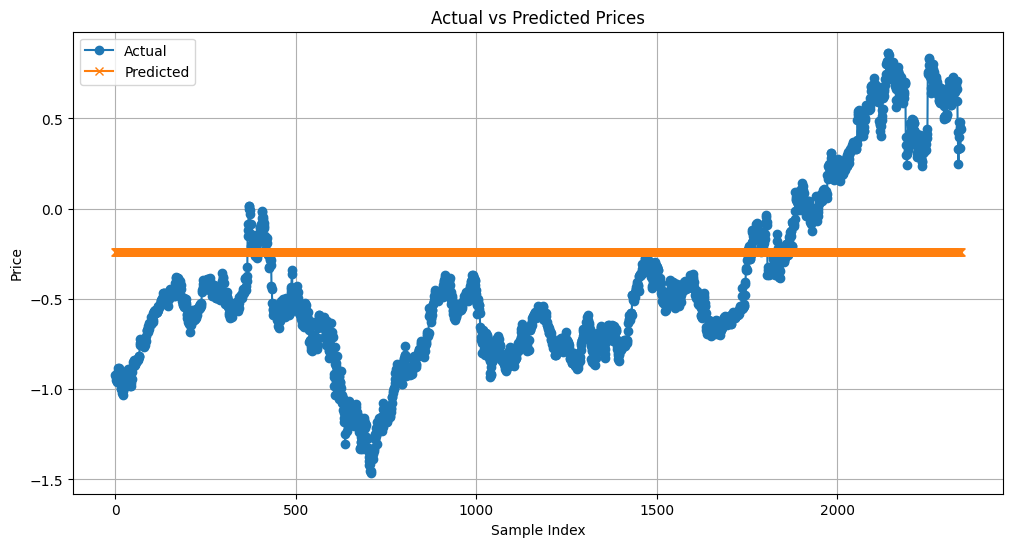

In [509]:
# Compute the performance of the model on the training data set
y_pred = opt_lstm_model_msft.predict(X_train_msft_array)
y_pred = y_pred.flatten()
y_true = y_train_msft_array.flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Plotting the actual vs predicted values

In [ ]:
# Predict on the test data
mae = mean_absolute_error(y_test_amzn_array, y_pred)
mse = mean_squared_error(y_test_amzn_array, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_amzn_array, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

- The stock prices are increasing over the period of time for all 4 stocks.
- The volume of the stocks is reducing over the period of time.